# Objects detection

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Objects-detection" data-toc-modified-id="Objects-detection-1">Objects detection</a></span><ul class="toc-item"><li><span><a href="#Dataset-load" data-toc-modified-id="Dataset-load-1.1">Dataset load</a></span></li><li><span><a href="#Object-detection-with-RetinaNet" data-toc-modified-id="Object-detection-with-RetinaNet-1.2">Object detection with RetinaNet</a></span></li><li><span><a href="#Object-detection-with-YOLOv3" data-toc-modified-id="Object-detection-with-YOLOv3-1.3">Object detection with YOLOv3</a></span></li><li><span><a href="#Labels-selections" data-toc-modified-id="Labels-selections-1.4">Labels selections</a></span></li><li><span><a href="#Object-detection-quality-assesment" data-toc-modified-id="Object-detection-quality-assesment-1.5">Object detection quality assesment</a></span><ul class="toc-item"><li><span><a href="#RetinaNet" data-toc-modified-id="RetinaNet-1.5.1">RetinaNet</a></span><ul class="toc-item"><li><span><a href="#Dog" data-toc-modified-id="Dog-1.5.1.1">Dog</a></span></li><li><span><a href="#Human" data-toc-modified-id="Human-1.5.1.2">Human</a></span></li><li><span><a href="#Any-animal" data-toc-modified-id="Any-animal-1.5.1.3">Any animal</a></span></li></ul></li><li><span><a href="#YOLOv3" data-toc-modified-id="YOLOv3-1.5.2">YOLOv3</a></span><ul class="toc-item"><li><span><a href="#Dog" data-toc-modified-id="Dog-1.5.2.1">Dog</a></span></li><li><span><a href="#Human" data-toc-modified-id="Human-1.5.2.2">Human</a></span></li><li><span><a href="#Any-animal" data-toc-modified-id="Any-animal-1.5.2.3">Any animal</a></span></li></ul></li></ul></li><li><span><a href="#Combined-quality" data-toc-modified-id="Combined-quality-1.6">Combined quality</a></span></li></ul></li></ul></div>

In [10]:
from glob import glob
import numpy as np
import pandas as pd
import sys,os
from imageai.Detection import ObjectDetection
import matplotlib.pyplot as plt
from sklearn.metrics import balanced_accuracy_score

## Dataset load

In [52]:
## Dataset descriptive

#parse files in dataset folder

columns = ['path','file_id', 'dog', 'human', 'animal_not_dog', 'dog_color', 'dog_tail']

def add_files(dataset_folder_path, dog, human, animal_not_dog, dog_color, dog_tail):
    dataset_files = []
    for path, subdirs, files in os.walk(dataset_folder_path):
        for name in files:
            if '_' not in name:
                dataset_files.append([os.path.join(path, name), name, dog, human, animal_not_dog, dog_color, dog_tail])
    return pd.DataFrame(dataset_files)


data = pd.concat([add_files("dataset\other_animals", 0, 0, 1, None, None)
                 ,add_files("dataset\empty", 0, 0, 0, None, None)
                 ,add_files("dataset\only_dog\mixed_long", 1, 0, 0, "mixed", "long")
                 ,add_files("dataset\only_dog\mixed_short", 1, 0, 0, "mixed", "short")
                 ,add_files("dataset\only_dog\light_long", 1, 0, 0, "light", "long")
                 ,add_files("dataset\only_dog\dark_long", 1, 0, 0, "dark", "long")
                 ,add_files("dataset\only_dog\dark_short", 1, 0, 0, "dark", "short")
                 ,add_files("dataset\only_dog\light_short", 1, 0, 0, "light", "short")
                 ,add_files("dataset\human_and_dog", 1, 1, 0, None, None)])

data.columns = columns

data['any_animal'] = data[['dog', 'animal_not_dog']].max(axis=1)

display(data.groupby(['dog', 'human', 'animal_not_dog', 'any_animal'])['path'].count().reset_index())
display(data.groupby(['dog', 'human', 'animal_not_dog', 'dog_color', 'dog_tail'])['path'].count().reset_index())

,dog,human,animal_not_dog,any_animal,path
0,0,0,0,0,324
1,0,0,1,1,294
2,1,0,0,1,1055
3,1,1,0,1,513


,dog,human,animal_not_dog,dog_color,dog_tail,path
0,1,0,0,dark,long,143
1,1,0,0,dark,short,211
2,1,0,0,light,long,175
3,1,0,0,light,short,243
4,1,0,0,mixed,long,123
5,1,0,0,mixed,short,160


## Object detection with RetinaNet

In [3]:
execution_path = os.getcwd()

detector = ObjectDetection()
detector.setModelTypeAsRetinaNet()
detector.setModelPath(os.path.join(execution_path , "resnet50_coco_best_v2.1.0.h5"))
detector.loadModel()

objects_all = []
result_folder = 'dataset_objects_resnet50'

for i, row in data.iterrows():
    try:
        execution_path = os.getcwd()

        detections, extracted_images = detector.detectObjectsFromImage(input_image=os.path.join(execution_path, row['path'])
                                                     , output_image_path=os.path.join(execution_path, result_folder + "/" + row['path'])
                                                     , minimum_percentage_probability=5
                                                     , extract_detected_objects=True
                                                     , display_percentage_probability=False
                                                     , display_object_name=False
                                                     , display_box=False)   

        for i in range(0, len(detections)):
            detections[i]['object_path'] = extracted_images[i]
            objects = pd.DataFrame(detections)
            objects['file_id'] = row['file_id']
        if objects.shape[0] > 0:
            objects_all.append(objects)
    except:
        print('Error in ' + row['path'])
    

objects_all = pd.concat(objects_all)
objects_all.to_csv(result_folder + '/all_objects.csv')

## Object detection with YOLOv3

In [5]:
execution_path = os.getcwd()

detector = ObjectDetection()
detector.setModelTypeAsYOLOv3()
detector.setModelPath(os.path.join(execution_path , "yolo.h5"))
detector.loadModel()

objects_all = []
result_folder = 'dataset_objects_yolo'

for i, row in data.iterrows():
    try:
        execution_path = os.getcwd()

        detections, extracted_images = detector.detectObjectsFromImage(input_image=os.path.join(execution_path, row['path'])
                                                     , output_image_path=os.path.join(execution_path, result_folder + "/" + row['path'])
                                                     , minimum_percentage_probability=5
                                                     , extract_detected_objects=True
                                                     , display_percentage_probability=False
                                                     , display_object_name=False
                                                     , display_box=False)   
        for i in range(0, len(detections)):
            detections[i]['object_path'] = extracted_images[i]
            objects = pd.DataFrame(detections)
            objects['file_id'] = row['file_id']
        if objects.shape[0] > 0:
            objects_all.append(objects)
    except:
        print('Error in ' + row['path'])
    

objects_all = pd.concat(objects_all)
objects_all.to_csv(result_folder + '/all_objects.csv')

In [6]:
#save results
data.to_excel('object_detection_result.xls', index=False)

## Labels selections

## Object detection quality assesment

In [20]:
def accuracy_calc(predicted_label,true_label,result_folder,model_label):
    
    objects_retina = pd.read_csv(result_folder + '/all_objects.csv')
    all_classes = ["person","bicycle","car","motorcycle","airplane","bus","train","truck","boat","trafficlight","firehydrant","stop_sign","parkingmeter","bench","bird","cat","dog","horse","sheep","cow","elephant","bear","zebra","giraffe","backpack","umbrella","handbag","tie","suitcase","frisbee","skis","snowboard","sportsball","kite","baseballbat","baseballglove","skateboard","surfboard","tennisracket","bottle","wineglass","cup","fork","knife","spoon","bowl","banana","apple","sandwich","orange","broccoli","carrot","hotdog","pizza","donot","cake","chair","couch","pottedplant","bed","diningtable","toilet","tv","laptop","mouse","remote","keyboard","cellphone","microwave","oven","toaster","sink","refrigerator","book","clock","vase","scissors","teddybear","hairdryer","toothbrush"]
    labels_stat = []

    for cl in all_classes:

        x = range(5, 100, 1)
        y = []

        for n in x:
            tmp = objects_retina[(objects_retina['name'] == cl)&(objects_retina['percentage_probability'] >= n)]
            data[predicted_label] = np.where(data['file_id'].isin(tmp['file_id']), 1, 0)
            y.append(balanced_accuracy_score(data[true_label], data[predicted_label]))

        if cl in model_labels:
            plt.plot(x, y)
            plt.xlabel('Model score')
            plt.ylabel('Balanced accuracy')
            plt.title(cl)
            plt.show()

        labels_stat.append([cl, x[np.argmax(y)], np.max(y)])

    res = pd.DataFrame(labels_stat)
    res.columns = ['class', 'min_prob', 'max_balanced_accuracy']
    res = res[res['max_balanced_accuracy'] > 0.55]
    display(res[res['max_balanced_accuracy'] > 0.55].sort_values(by='max_balanced_accuracy', ascending=False))
    res_ = list(zip(res['class'], res['min_prob']))

    def sub_lists(l):
        lists = [[]]
        for i in range(len(l) + 1):
            for j in range(i):
                lists.append(l[j: i])
        return lists

    labels_stat = []

    for cl in sub_lists(res_):
        if len(cl) > 0:
            tmp = []
            for cl_ in cl:            
                tmp.append(objects_retina[(objects_retina['name'] == cl_[0])&(objects_retina['percentage_probability'] >= cl_[1])])
            tmp = pd.concat(tmp)
            tmp = tmp.drop_duplicates()
            data[predicted_label] = np.where(data['file_id'].isin(tmp['file_id']), 1, 0)
            labels_stat.append([cl, balanced_accuracy_score(data[true_label], data[predicted_label])])    

    labels_stat = pd.DataFrame(labels_stat)
    labels_stat.columns = ['label', 'balanced_accuracy']
    display(labels_stat.sort_values(by='balanced_accuracy', ascending=False).head(10))

### RetinaNet

#### Dog

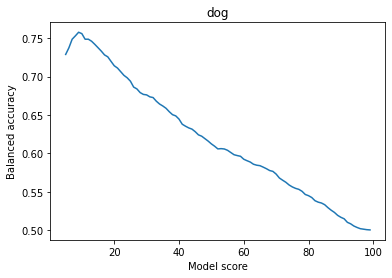

,class,min_prob,max_balanced_accuracy
16,dog,9,0.757699
18,sheep,5,0.740485
15,cat,5,0.683859
17,horse,9,0.670219
19,cow,8,0.660296
0,person,58,0.631303
29,frisbee,5,0.620205
14,bird,5,0.611979
36,skateboard,5,0.607592
20,elephant,5,0.605906


,label,balanced_accuracy
9,"[(dog, 9)]",0.757699
20,"[(sheep, 5)]",0.740485
8,"[(cat, 5), (dog, 9)]",0.731554
18,"[(dog, 9), (horse, 9), (sheep, 5)]",0.726348
13,"[(dog, 9), (horse, 9)]",0.723321
19,"[(horse, 9), (sheep, 5)]",0.722978
26,"[(sheep, 5), (cow, 8)]",0.704660
24,"[(dog, 9), (horse, 9), (sheep, 5), (cow, 8)]",0.701739
17,"[(cat, 5), (dog, 9), (horse, 9), (sheep, 5)]",0.697865
25,"[(horse, 9), (sheep, 5), (cow, 8)]",0.697512


In [21]:
predicted_label = 'dog_predicted_retina'
true_label = 'dog'
result_folder = 'dataset_objects_resnet50'
model_labels = ['dog']

accuracy_calc(predicted_label,true_label,result_folder,model_label)

#### Human

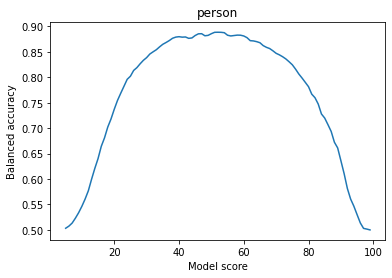

,class,min_prob,max_balanced_accuracy
0,person,52,0.888427
26,handbag,8,0.760598
24,backpack,10,0.729719
36,skateboard,7,0.714620
28,suitcase,7,0.627505
31,snowboard,5,0.613235
16,dog,10,0.605965
37,surfboard,5,0.603016
30,skis,5,0.589544
29,frisbee,6,0.581598


,label,balanced_accuracy
0,"[(person, 52)]",0.888427
54,"[(handbag, 8)]",0.760598
35,"[(backpack, 10)]",0.729719
118,"[(snowboard, 5), (skateboard, 7)]",0.723003
117,"[(skis, 5), (snowboard, 5), (skateboard, 7)]",0.722823
119,"[(skateboard, 7)]",0.714620
64,"[(handbag, 8), (suitcase, 7)]",0.692564
132,"[(skis, 5), (snowboard, 5), (skateboard, 7), (...",0.691978
116,"[(frisbee, 6), (skis, 5), (snowboard, 5), (ska...",0.690860
133,"[(snowboard, 5), (skateboard, 7), (surfboard, 5)]",0.688130


In [22]:
predicted_label = 'dog_predicted_retina'
true_label = 'human'
result_folder = 'dataset_objects_resnet50'
model_labels = ['person']

accuracy_calc(predicted_label,true_label,result_folder,model_label)

#### Any animal

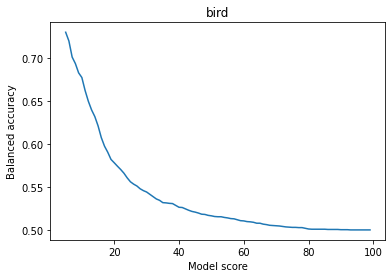

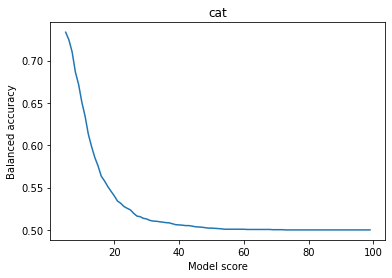

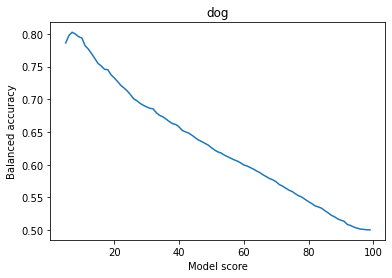

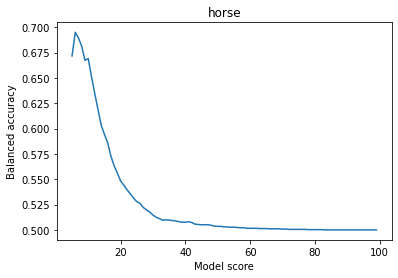

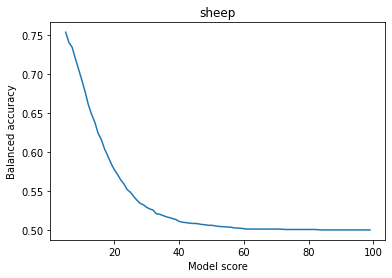

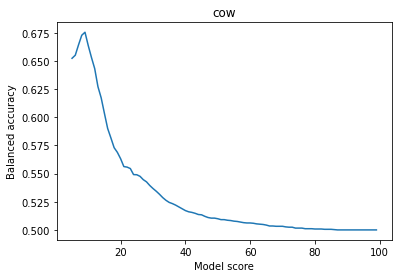

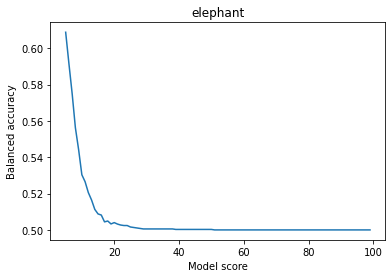

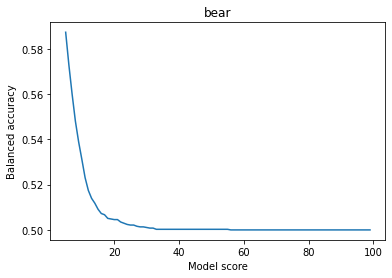

,class,min_prob,max_balanced_accuracy
16,dog,7,0.802390
18,sheep,5,0.753524
15,cat,5,0.733384
14,bird,5,0.729668
17,horse,6,0.695054
19,cow,9,0.675593
0,person,42,0.636310
29,frisbee,5,0.633485
36,skateboard,6,0.630758
20,elephant,5,0.608814


,label,balanced_accuracy
9,"[(dog, 7)]",0.802390
8,"[(cat, 5), (dog, 7)]",0.792205
7,"[(bird, 5), (cat, 5), (dog, 7)]",0.758424
20,"[(sheep, 5)]",0.753524
1,"[(person, 42), (bird, 5)]",0.752513
3,"[(person, 42), (bird, 5), (cat, 5)]",0.750983
6,"[(person, 42), (bird, 5), (cat, 5), (dog, 7)]",0.750854
4,"[(bird, 5), (cat, 5)]",0.748213
26,"[(sheep, 5), (cow, 9)]",0.736028
5,"[(cat, 5)]",0.733384


In [50]:
predicted_label = 'dog_predicted_retina'
true_label = 'any_animal'
result_folder = 'dataset_objects_resnet50'
model_labels = ['bird', 'dog', 'cat', 'cow', 'horse', 'sheep', 'elephant', 'bear']

accuracy_calc(predicted_label,true_label,result_folder,model_label)

### YOLOv3

#### Dog

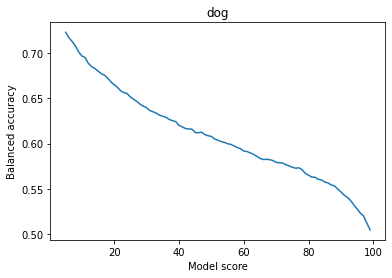

,class,min_prob,max_balanced_accuracy
16,dog,5,0.723111
0,person,52,0.631480


,label,balanced_accuracy
1,"[(person, 52), (dog, 5)]",0.752007
2,"[(dog, 5)]",0.723111
0,"[(person, 52)]",0.631480


In [24]:
predicted_label = 'dog_predicted_retina'
true_label = 'dog'
result_folder = 'dataset_objects_yolo'
model_labels = ['dog']

accuracy_calc(predicted_label,true_label,result_folder,model_label)

#### Human

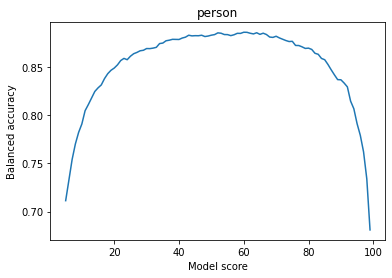

,class,min_prob,max_balanced_accuracy
0,person,60,0.885854
26,handbag,5,0.628189
16,dog,5,0.608413
24,backpack,5,0.574946
1,bicycle,5,0.573015


,label,balanced_accuracy
0,"[(person, 60)]",0.885854
1,"[(person, 60), (bicycle, 5)]",0.850186
3,"[(person, 60), (bicycle, 5), (dog, 5)]",0.715724
10,"[(person, 60), (bicycle, 5), (dog, 5), (backpa...",0.715503
6,"[(person, 60), (bicycle, 5), (dog, 5), (backpa...",0.714828
12,"[(dog, 5), (backpack, 5), (handbag, 5)]",0.673691
11,"[(bicycle, 5), (dog, 5), (backpack, 5), (handb...",0.665508
8,"[(dog, 5), (backpack, 5)]",0.649454
13,"[(backpack, 5), (handbag, 5)]",0.648826
7,"[(bicycle, 5), (dog, 5), (backpack, 5)]",0.645702


In [25]:
predicted_label = 'dog_predicted_retina'
true_label = 'human'
result_folder = 'dataset_objects_yolo'
model_labels = ['person']

accuracy_calc(predicted_label,true_label,result_folder,model_label)


#### Any animal

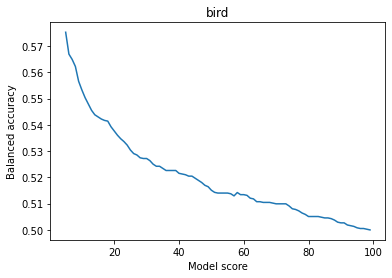

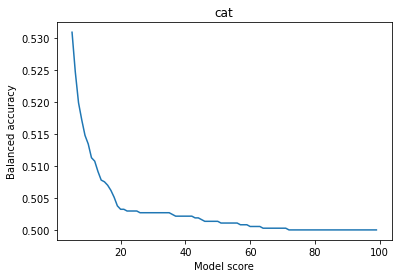

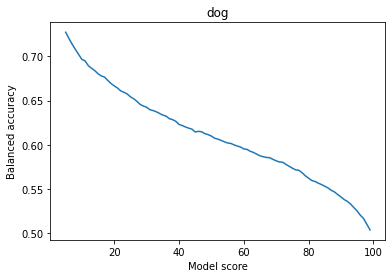

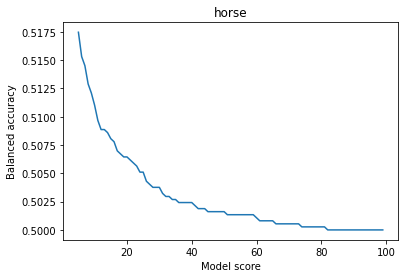

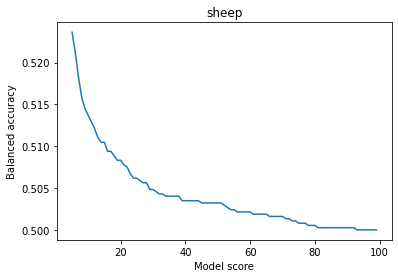

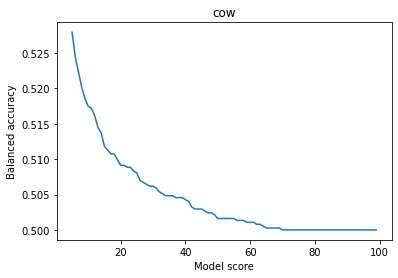

,class,min_prob,max_balanced_accuracy
16,dog,5,0.727178
0,person,55,0.630861
14,bird,5,0.575259


,label,balanced_accuracy
3,"[(person, 55), (bird, 5), (dog, 5)]",0.786883
4,"[(bird, 5), (dog, 5)]",0.754908
5,"[(dog, 5)]",0.727178
1,"[(person, 55), (bird, 5)]",0.682221
0,"[(person, 55)]",0.630861
2,"[(bird, 5)]",0.575259


In [51]:
predicted_label = 'dog_predicted_retina'
true_label = 'any_animal'
result_folder = 'dataset_objects_yolo'
model_labels = ['bird', 'dog', 'cat', 'cow', 'horse', 'sheep']

accuracy_calc(predicted_label,true_label,result_folder,model_label)

## Combined quality

In [54]:
#retina
result_folder = 'dataset_objects_resnet50'
objects_retina = pd.read_csv(result_folder + '/all_objects.csv')
#person
tmp = objects_retina[(objects_retina['name'] == 'person')&(objects_retina['percentage_probability'] >= 52)]
data['human_predict_resnet'] = np.where(data['file_id'].isin(tmp['file_id']), 1, 0)
#any animal
tmp = objects_retina[((objects_retina['name'] == 'dog')&(objects_retina['percentage_probability'] >= 7))]
data['any_animal_predict_resnet'] = np.where(data['file_id'].isin(tmp['file_id']), 1, 0)
#dog
tmp = objects_retina[(objects_retina['name'] == 'dog')&(objects_retina['percentage_probability'] >= 9)]
data['dog_predict_resnet'] = np.where(data['file_id'].isin(tmp['file_id']), 1, 0)

#yolo
result_folder = 'dataset_objects_yolo'
objects_retina = pd.read_csv(result_folder + '/all_objects.csv')
#person
tmp = objects_retina[(objects_retina['name'] == 'person')&(objects_retina['percentage_probability'] >= 60)]
data['human_predict_yolo'] = np.where(data['file_id'].isin(tmp['file_id']), 1, 0)
#any animal
tmp = objects_retina[((objects_retina['name'] == 'bird')&(objects_retina['percentage_probability'] >= 5))
                    |((objects_retina['name'] == 'dog')&(objects_retina['percentage_probability'] >= 5))]
data['any_animal_predict_yolo'] = np.where(data['file_id'].isin(tmp['file_id']), 1, 0)
#dog
tmp = objects_retina[(objects_retina['name'] == 'dog')&(objects_retina['percentage_probability'] >= 5)]
data['dog_predict_yolo'] = np.where(data['file_id'].isin(tmp['file_id']), 1, 0)


data['human_predict'] = data['human_predict_yolo'] | data['human_predict_resnet']
data['any_animal_predict'] = data['any_animal_predict_yolo'] | data['any_animal_predict_resnet']
data['dog_predict'] = data['dog_predict_yolo'] | data['dog_predict_resnet']

print('\nOnly Resnet')
print('Owner detection balanced accuracy:', balanced_accuracy_score(data['human'], data['human_predict_resnet']))
print('Any animals detection balanced accuracy:', balanced_accuracy_score(data['any_animal'], data['any_animal_predict_resnet']))
print('Dogs detection balanced accuracy:', balanced_accuracy_score(data['dog'], data['dog_predict_resnet']))

print('\nOnly Yolo')
print('Owner detection balanced accuracy:', balanced_accuracy_score(data['human'], data['human_predict_yolo']))
print('Any animals detection balanced accuracy:', balanced_accuracy_score(data['any_animal'], data['any_animal_predict_yolo']))
print('Dogs detection balanced accuracy:', balanced_accuracy_score(data['dog'], data['dog_predict_yolo']))

print('\nOnly Resnet+Yolo')
print('Owner detection balanced accuracy:', balanced_accuracy_score(data['human'], data['human_predict']))
print('Any animals detection balanced accuracy:', balanced_accuracy_score(data['any_animal'], data['any_animal_predict']))
print('Dogs detection balanced accuracy:', balanced_accuracy_score(data['dog'], data['dog_predict']))


Only Resnet
Owner detection balanced accuracy: 0.8884274843314702
Any animals detection balanced accuracy: 0.8023895718131306
Dogs detection balanced accuracy: 0.7576994997027937

Only Yolo
Owner detection balanced accuracy: 0.8858536392119303
Any animals detection balanced accuracy: 0.7549081035923142
Dogs detection balanced accuracy: 0.7231110890958325

Only Resnet+Yolo
Owner detection balanced accuracy: 0.8907158645101829
Any animals detection balanced accuracy: 0.821662290647253
Dogs detection balanced accuracy: 0.776713476652797
